<a href="https://colab.research.google.com/github/hyunbini/Project/blob/main/IDSL_LAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Library

In [384]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from google.colab import drive
drive.mount('/content/drive')
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import cv2
from google.colab.patches import cv2_imshow
import requests

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


User-defined Function used in code

In [385]:
def check_nan(file):
  result = file.isnull().sum()
  return result

In [386]:
#Function that extracts user_id who wrote one or more reviews
#Input : series(pandas dataframe)
#Output : result(list)
def make_list(series1):
  result = []
  for i in range(series1.size):
    #Add user_id who have written reviews more than once to the new list
    if series1[i]>1:
      result.append(series1.index[i])
  return result

In [387]:
#Function that erases unnecessary characters and makes a list of only the necessary data
#Input : list1(list)
#Output : result_listset(list)
def remove_special(list1):
  #Change list to string
  for i in range(len(list1)):
    list1[i] = str(list1[i])
  listset_str = ' '.join(list1)
  #Remove Special characters to space
  listset_str = re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]', "",listset_str)
  #Split the data by space
  result_listset = listset_str.split(' ')
  return result_listset

In [388]:
#Function that labels data composed of complex characters numerically based on ascending order\
#Input : list1(list to be replaced), list2(reference list), dic(dictionary to store the values of reference list and its unique labeling numbers)
#Output : list_df(Dataframe made from a labeled list)
def labeling_user_id(list1,list2,dic):
  i = 0
  for data in list1:
    if data in list2:
      if data in dic.keys():
        list1[i] = dic[data]
      else:
        dic[data] = i
        list1[i] = i
      i = i+1
    else:
      list1[i] = i
      i = i+1
  for y in range(len(list1)):
    list1[y] = list1[y]+1
  list_df = pd.DataFrame(data=list1, columns= ['labeling_user_id'])
  return list_df

In [389]:
#Function that make a list with data that goes up from zero to a list that goes up in ascending order
#Input : dataframe
#Output : list
def make_label_list(dataset_name):
  emptylist = []
  for i in range(len(dataset_name)):
    emptylist.append(i)
    i = i+1
  list_df_1 = pd.DataFrame(data=emptylist, columns=['labeling_list'])
  return list_df_1

In [390]:
#Function that removes unnecessary sentence symbols, case-sensive, and meaningless word in a sentence to vectorize
#Input : string
#Output : string
def text_preprocessing(column):
    #Make all words with lower letters
    column = column.str.lower()
    #Remove unnecessary punctuation marks
    column = column.str.replace('[-=+,#?^@*\"※~ㆍ!』‘|\(\)\[\]\{\}`\'…》\"\"\“\’·]', '', case=False)
    #Spliting each sentence to words to apply erase meaningless word
    word_tokens = column.str.split()
    keywords = word_tokens.apply(lambda x: [item for item in x if item not in stop])
    #assemble words of each sentence again and assign them in new column
    for i in range(len(keywords)):
        keywords[i] = " ".join(keywords[i])
        column = keywords
    return column

In [391]:
#Function that receives the parent_asin of the review product user wrote using the user_id after receiving the user_id
#Input : float
#Output : string
def found_asin(user_id):
  label = reviewdata['user_id']
  label_df_list = label.to_list()
  save_asin = []
  for data in label_df_list:
    if data == user_id:
      save_asin.append(data)
  if (len(save_asin)) == 1:
    return reviewdata[reviewdata['user_id'] == user_id]['parent_asin'].values[0]
  elif (len(save_asin)) > 1:
    for data_1 in save_asin:
      high_data = float(reviewdata[reviewdata['user_id']==data_1]['rating'].values[0])
      if float(reviewdata[reviewdata['user_id']==data_1]['rating'].values[0])>high_data:
        high_value = float(reviewdata[reviewdata['user_id']==data_1]['rating'].values[0])
      else:
        high_value = high_data
    return reviewdata[reviewdata['rating']==high_value]['parent_asin'].values[0]
  else:
    print("Wrong User_id, Please try again 1~70883.")

In [392]:
#Function to find the details of the product that fit parent_asin
#Input : string
#Output : string
def found_data(asin_id):
  asindata = metadata['parent_asin']
  asindata_df_list = asindata.to_list()
  for dt in asindata_df_list:
    if dt == asin_id:
      return metadata[metadata['parent_asin'] == asin_id]['details'].values[0]

In [393]:
#Function that receives the url for the product and show the image
#Input : string
#Output : Image or String
def image_show(dataurl):
    dataurl_str = ''.join(dataurl)
    url = re.sub('[=+,#?^@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]', "",dataurl_str)
    dataurl_list = url.split()
    url_list = [s for s in dataurl_list if "https://" in s][0]
    url_data = ''.join(url_list)
    image_nparray = np.asarray(bytearray(requests.get(url_data).content), dtype=np.uint8)
    image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR)
    if str(type(image)) == "<class 'numpy.ndarray'>":
      image_final = cv2.resize(image,(100,100))
      cv2_imshow(image_final)
      cv2.waitKey(0)
    else:
      print("Sorry, There is no image for this product.")

Import Data and Remove NaN Value and Unuseful Columns



In [394]:
meta_json = pd.read_json('/content/drive/MyDrive/IDSL Recruitment/[Data 1] Eng - Review Analysis/metadata.json')
review_json = pd.read_json('/content/drive/MyDrive/IDSL Recruitment/[Data 1] Eng - Review Analysis/reviews.json')
print(meta_json.head())
print(review_json.head())
print(check_nan(meta_json))
print(check_nan(review_json))

  main_category                                              title  \
0    All Beauty  Howard LC0008 Leather Conditioner, 8-Ounce (4-...   
1    All Beauty  Lurrose 100Pcs Full Cover Fake Toenails Artifi...   
2    All Beauty                         Gold extatic Musk EDT 90ml   
3    All Beauty  Brand New Headrang Face line Contour V-line Ma...   
4    All Beauty  7 Packs Deep Wave Crochet Hair 22 Inch Deep wa...   

   average_rating  rating_number  \
0             4.8             10   
1             3.7             35   
2             3.7              2   
3             3.3              4   
4             3.4             10   

                                            features  \
0                                                 []   
1  [The false toenails are durable with perfect l...   
2  [Extatic Balmain Gold Musk By Balmain Edt Spra...   
3                                                 []   
4                                                 []   

                         

In [395]:
meta = meta_json.drop(['rating_number','categories','videos', 'bought_together', 'subtitle', 'author'],axis = 1)
print(meta.head())
reviewdata = review_json.drop(['title', 'text','images','timestamp','helpful_vote','verified_purchase'],axis=1)
print(reviewdata.head())

  main_category                                              title  \
0    All Beauty  Howard LC0008 Leather Conditioner, 8-Ounce (4-...   
1    All Beauty  Lurrose 100Pcs Full Cover Fake Toenails Artifi...   
2    All Beauty                         Gold extatic Musk EDT 90ml   
3    All Beauty  Brand New Headrang Face line Contour V-line Ma...   
4    All Beauty  7 Packs Deep Wave Crochet Hair 22 Inch Deep wa...   

   average_rating                                           features  \
0             4.8                                                 []   
1             3.7  [The false toenails are durable with perfect l...   
2             3.7  [Extatic Balmain Gold Musk By Balmain Edt Spra...   
3             3.3                                                 []   
4             3.4                                                 []   

                                         description  price  \
0                                                 []   None   
1  [Description, The

Extracting duplicate data and labeling of the user_id value to be used for prediction

In [396]:
id = reviewdata['user_id']
print("The total number of reviews is", id.size)
id_count = (id.value_counts())
print("The user who wrote the review is", id_count.size)
#Create only unique values of the user_id as a list
dup_ind = make_list(id_count)

The total number of reviews is 70883
The user who wrote the review is 68934


<ipython-input-386-e8b33d3049f5>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if series1[i]>1:


In [397]:
new_user_id = id.to_list()
#Erase unnecessary character symbols
result_dup_id = remove_special(dup_ind)
result_user_id = remove_special(new_user_id)
label_dic = {}
#New labeling of user_id for ease of use
reviewdata['user_id'] = labeling_user_id(result_user_id,result_dup_id,label_dic)

In [398]:
#Create a product label to use when extracting a recommend product in the prediction part
new_label_df = make_label_list(meta)

In [399]:
#Combine meta and new_label_df dataset into one dataframe
metadata = pd.concat([meta,new_label_df],axis=1)
print(metadata.head())
print(reviewdata.head())

  main_category                                              title  \
0    All Beauty  Howard LC0008 Leather Conditioner, 8-Ounce (4-...   
1    All Beauty  Lurrose 100Pcs Full Cover Fake Toenails Artifi...   
2    All Beauty                         Gold extatic Musk EDT 90ml   
3    All Beauty  Brand New Headrang Face line Contour V-line Ma...   
4    All Beauty  7 Packs Deep Wave Crochet Hair 22 Inch Deep wa...   

   average_rating                                           features  \
0             4.8                                                 []   
1             3.7  [The false toenails are durable with perfect l...   
2             3.7  [Extatic Balmain Gold Musk By Balmain Edt Spra...   
3             3.3                                                 []   
4             3.4                                                 []   

                                         description  price  \
0                                                 []   None   
1  [Description, The

Data Visualization

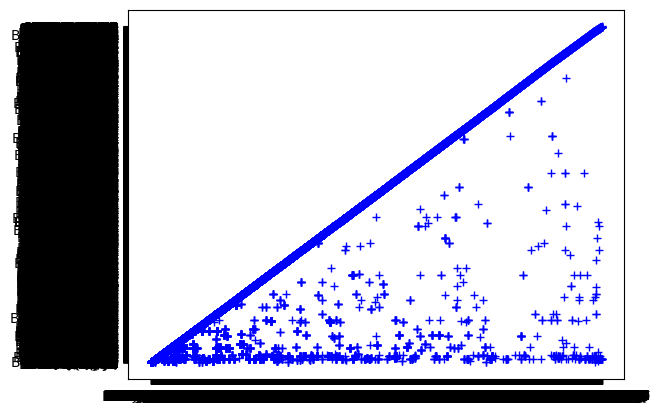

In [400]:
asin = reviewdata['asin']
asin_parent = reviewdata['parent_asin']
plt.plot(asin,asin_parent, 'b+')
plt.show()

Modeling

In [401]:
#Get details data for text processing
details_df = metadata['details']
details_str_df = details_df.astype(str)
tp_details_df = text_preprocessing(details_str_df)

In [402]:
CV = CountVectorizer()
#Make metrix used string
converted_metrix = CV.fit_transform(tp_details_df)
cs_result = cosine_similarity(converted_metrix)

Prediction

Please enter your own user_id : 559
FUNOC Eyebrow Smooth Waterproof Cosmetic Beauty Makeup Eyebrow Pen Pencil With Brush 3 None


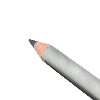

In [403]:
id = input("Please enter your own user_id : ")
id_float = float(id)
review_parent_asin = found_asin(id_float)
#Get the product information that user have already bought
already_buy_title = metadata[metadata['parent_asin']==review_parent_asin]['title'].values[0]
already_buy_price = metadata[metadata['title']==already_buy_title]['price'].values[0]
already_buy_rating = reviewdata[reviewdata['parent_asin']==review_parent_asin]['rating'].values[0]
already_buy_data = str(metadata[metadata['title']==already_buy_title]['images'].values[0])
print(already_buy_title,already_buy_rating,already_buy_price)
image_show(already_buy_data)
#Get the product details that user have already bought
user_inform_data = found_data(review_parent_asin)
pred_data = metadata[metadata['details'].str.contains(user_inform_data)]

In [404]:
labeling_id = pred_data['labeling_list'].values[0]
#Calculation of similarity with cosine similarity
score = list(enumerate(cs_result[labeling_id]))
#Sort the similar product in descending order
sorted_score = sorted(score, key=lambda x:x[1], reverse= True)
#Ignore the first score because it's the same
item_list_based_score = sorted_score[1:11]

1 Tattoo Eyebrow Pen Liquid Eyebrow Pencil with Fork Tip Long-lasting Waterproof Brow Eyebrow Eyeliner Pencil Brow Gel for Creating Natural Eyes Makeup Drawing Eyebrow and Eyeliner (Brown) 3.2 None {"Brand": "UNIQUE2U", "Item Form": "Pencil", "Special Feature": "Long Lasting", "Material Feature": "Natural", "Skin Type": "All", "Is Discontinued By Manufacturer": "No", "Package Dimensions": "4.8 x 0.79 x 0.55 inches; 0.63 Ounces"}


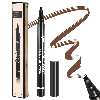

2 Yuxuan Eyebrow Tattoo Pen Microblading Eyebrow Pencil with a Micro-Fork Tip Applicator Creates Natural Looking Brows Effortlessly and Stays on All Day(1 pc/set,Reddish Brown) 3.2 None {"Item Form": "Pencil", "Special Feature": "Natural Looking", "Material Feature": "Natural", "Skin Type": "All", "Specialty": "Long Lasting", "Is Discontinued By Manufacturer": "No", "Package Dimensions": "6.6 x 2.5 x 0.4 inches; 0.81 Ounces", "UPC": "738770594107"}


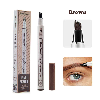

3 Yuxuan Eyebrow Tattoo Pen Microblading Eyebrow Pencil with a Micro-Fork Tip Applicator Creates Natural Looking Brows Effortlessly and Stays on All Day(1 pcs/set.Chestnut) 3.5 None {"Item Form": "Pencil", "Special Feature": "Natural Looking", "Material Feature": "Natural", "Skin Type": "All", "Specialty": "Long Lasting", "Is Discontinued By Manufacturer": "No", "Product Dimensions": "0.8 x 1 x 4 inches; 0.35 Ounces", "UPC": "738770594169"}


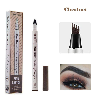

4 3D Eyebrow Pencil Durable Eyebrow Pencil with Soft Brush Girl Eyebrow Shaping Pencil light brown 4.4 None {"Brand": "Eyebrow Pencil", "Item Form": "Pencil", "Material Feature": "Natural", "Product Benefits": "Softening", "Skin Type": "All", "Package Dimensions": "5.5 x 1.1 x 0.2 inches; 0.63 Ounces", "Item model number": "SJOO-MB"}


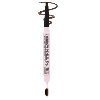

5 HIROCK 3 in 1 eyebrow pencil Long lasting and Waterproof Professional Makeup Auto Eyebrow Pencil (04# Gray) 4.0 None {"Brand": "HIROCK", "Item Form": "Pencil", "Special Feature": "Waterproof, Long Lasting", "Material Feature": "Natural", "Product Benefits": "Long Lasting", "Is Discontinued By Manufacturer": "No", "Package Dimensions": "6.89 x 0.87 x 0.71 inches; 2.12 Ounces", "Item model number": "MB-3S", "UPC": "718979017959"}


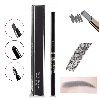

In [405]:
rank = 1
for item in item_list_based_score:
    #Get the product information that recommend based on cosine similarity
    title = metadata[metadata['labeling_list'] == item[0]]['title'].values[0]
    rating = metadata[metadata['title']==title]['average_rating'].values[0]
    price = metadata[metadata['title']==title]['price'].values[0]
    detail = metadata[metadata['title']==title]['details'].values[0]
    data = str(metadata[metadata['title']==title]['images'].values[0])
    print(rank,title,rating,price,detail)
    image_show(data)
    rank = rank+1
    #Show top 5 product
    if rank > 5:
        break